# GSTN Hackathon 2024

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

import optuna
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import average_precision_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

/Users/himan/Documents/projects/gstn_hackathon_2024/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_X_train = pd.read_csv("../input/Train_60/X_Train_Data_Input.csv")
df_y_train = pd.read_csv("../input/Train_60/Y_Train_Data_Target.csv")
df_X_test = pd.read_csv("../input/Test_20/X_Test_Data_Input.csv")
df_y_test = pd.read_csv("../input/Test_20/Y_Test_Data_Target.csv")

In [3]:
def feature_engineering(df, assets_filepath):
    # 0 is the most frequent value in 'Column0'
    df.loc[df["Column0"].isna()] = 0

    # Impute values
    impute_values = {
        "Column9": "median",
        "Column14": 0.0013506071853317501,
        "Column5": -0.0074686502841777,
        "Column4": 0.0621205346920356,
        "Column3": 0.27213270929052197,
        "Column15": 0.0033900985562439,
        "Column6": -0.407939121815475,
        "Column8": -0.28394554507395087,
    }
    for col in impute_values.keys():
        df[f'{col}_MI_flag'] = 0
        df.loc[df[col].isna(), f'{col}_MI_flag'] = 1
        if impute_values[col] == 'median':
            df.loc[df[col].isna(), col] = df[col].median()
        else:
            df.loc[df[col].isna(), col] = impute_values[col]
    
    # Drop column 9
    df = df.drop('Column9', axis=1)
    
    # Transform negative values in column 1
    neg_col1 = (df['Column1'] < 0)
    df.loc[neg_col1, 'Column1'] = df['Column1'].max() - df.loc[neg_col1, 'Column1']
    
    # df["Column2"] = boxcox((df["Column2"] - df["Column2"].min()) / (df["Column2"].max() - df["Column2"].min()) + 1)[0]

    # Transform column 3 and 4
    df["Column3_4"] = df['Column3'] - df['Column4'] # non-commutative
    # df = df.drop(['Column3', 'Column4'], axis=1)

    # Add function of column 6 and 8
    df["Column6_8"] = df['Column6'] * df['Column8']

    # Load assets is not training
    assets = joblib.load(assets_filepath)

    # Make outlier indicator
    for col in ["Column6", "Column7", "Column8"]:
        df[f'{col}_isof'] = assets["isoforests"][col].predict(df[[col]])
    
    # Select features
    df = df[assets['feature_cols']]

    return df

In [4]:
X_train = feature_engineering(df_X_train, assets_filepath='../models/isoforestsFS1.joblib')
X_test = feature_engineering(df_X_test, assets_filepath='../models/isoforestsFS1.joblib')

y_train = df_y_train['target']
y_test = df_y_test['target']

In [5]:
train_mask = (X_train["Column18"]==0) | (X_train["Column1"]==2495)
test_mask = (X_test["Column18"]==0) | (X_test["Column1"]==2495)

In [6]:
saved_obj = joblib.load('../models/stackEnsembleV1.joblib')
primary_estimators, final_estimator = saved_obj['primary_estimators'], saved_obj['final_estimator']

In [7]:
final_estimator.coef_

array([[ 0.9065319 ,  0.90453104, -0.00603586,  0.94985352,  0.888228  ,
         0.90053607,  0.84918694,  0.84725493]])

## Hyper-parameter tuning

In [8]:
# Optimizing XGBoost model
def objective(trial):
    MODEL_TUNING = "xgboost" # "xgboost" "random_forest" "lightgbm"

    if MODEL_TUNING == "catboost":
        model = CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 1000),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
            silent=True,
            allow_writing_files=False,
        )
        model.fit(X_train[~train_mask], y_train[~train_mask])
        pred_probs = model.predict_proba(X_test[~test_mask])[:, 1]

    elif MODEL_TUNING == "random_forest":
        # Suggest values for hyperparameters
        n_estimators = trial.suggest_int("n_estimators", 100, 500, log=True)
        max_depth = trial.suggest_int("max_depth", 2, 64)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

        # Create and fit random forest model
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
        )
        model.fit(X_train[~train_mask], y_train[~train_mask])
        pred_probs = model.predict_proba(X_test[~test_mask])[:, 1]

    elif MODEL_TUNING == "xgboost":
        dtrain = xgb.DMatrix(X_train[~train_mask], label=y_train[~train_mask])
        dvalid = xgb.DMatrix(X_test[~test_mask], label=y_test[~test_mask])

        param = {
            "verbosity": 0,
            "objective": "binary:logistic",
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        }

        bst = xgb.train(param, dtrain)
        pred_probs = bst.predict(dvalid)
    
    elif MODEL_TUNING == "lightgbm":
        param_grid = {
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
            "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
            "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
            "bagging_fraction": trial.suggest_float(
                "bagging_fraction", 0.2, 0.95, step=0.1
            ),
            "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
            "feature_fraction": trial.suggest_float(
                "feature_fraction", 0.2, 0.95, step=0.1
            ),
        }
        model = LGBMClassifier(random_state=42, force_col_wise=True, **param_grid)
        model.fit(X_train[~train_mask], y_train[~train_mask])
        pred_probs = model.predict_proba(X_test[~test_mask])[:, 1]

    score = average_precision_score(y_score=pred_probs, y_true=y_test[~test_mask])
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-09-17 17:21:23,588] A new study created in memory with name: no-name-008128d0-9b62-4d14-aaf4-a1b70e443180
[I 2024-09-17 17:21:23,682] Trial 0 finished with value: 0.9213083065255155 and parameters: {'lambda': 1.3350679944171032e-08, 'alpha': 0.007654811843219646, 'subsample': 0.6218602439271308, 'colsample_bytree': 0.6315444649925579, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.022227470033200445, 'gamma': 3.935028572181243e-05}. Best is trial 0 with value: 0.9213083065255155.
[I 2024-09-17 17:21:23,778] Trial 1 finished with value: 0.9327909376191711 and parameters: {'lambda': 0.0039801736192982525, 'alpha': 0.039095238540707254, 'subsample': 0.34351191501899336, 'colsample_bytree': 0.7090875225227671, 'max_depth': 9, 'min_child_weight': 8, 'eta': 0.009742922057982566, 'gamma': 8.130197436011453e-08}. Best is trial 1 with value: 0.9327909376191711.
[I 2024-09-17 17:21:23,868] Trial 2 finished with value: 0.932627076072392 and parameters: {'lambda': 0.005081986976963107, 'a

Number of finished trials:  100
Best trial:
  Value: 0.9375454867570935
  Params: 
    lambda: 2.4021389342306087e-08
    alpha: 0.00027404857224803367
    subsample: 0.6860462439602264
    colsample_bytree: 0.7818469402557029
    max_depth: 9
    min_child_weight: 4
    eta: 0.30421096193676095
    gamma: 0.30569180117084993


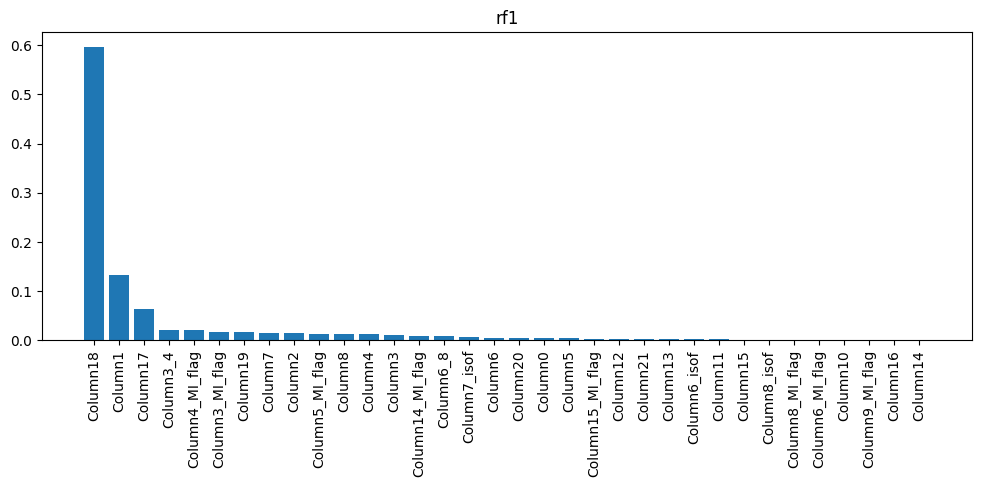

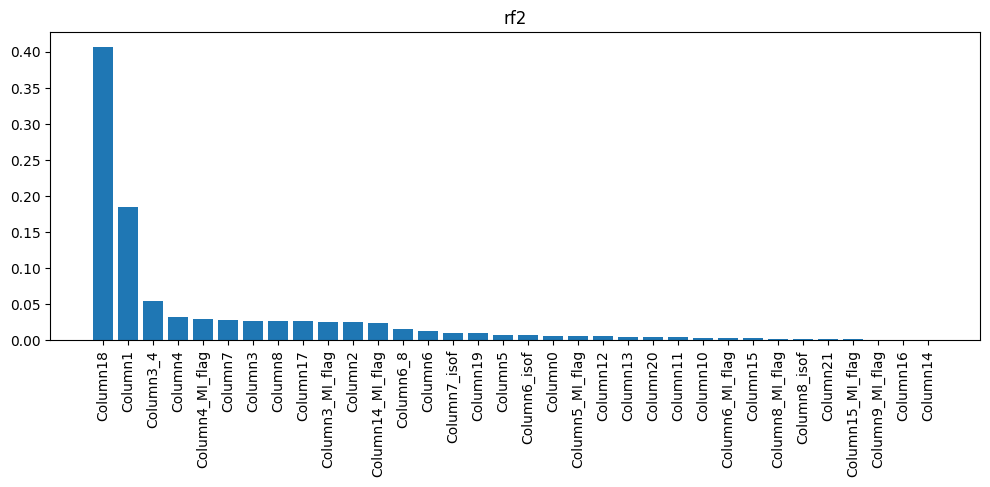

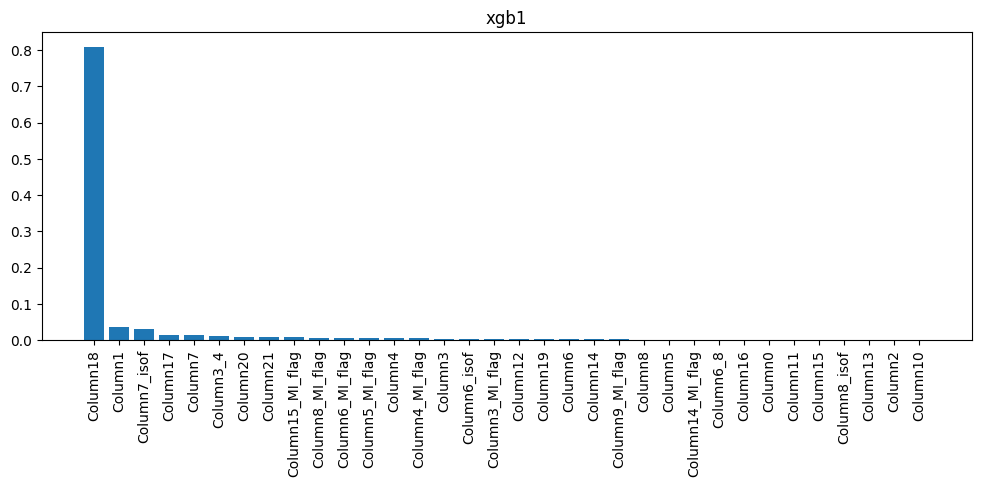

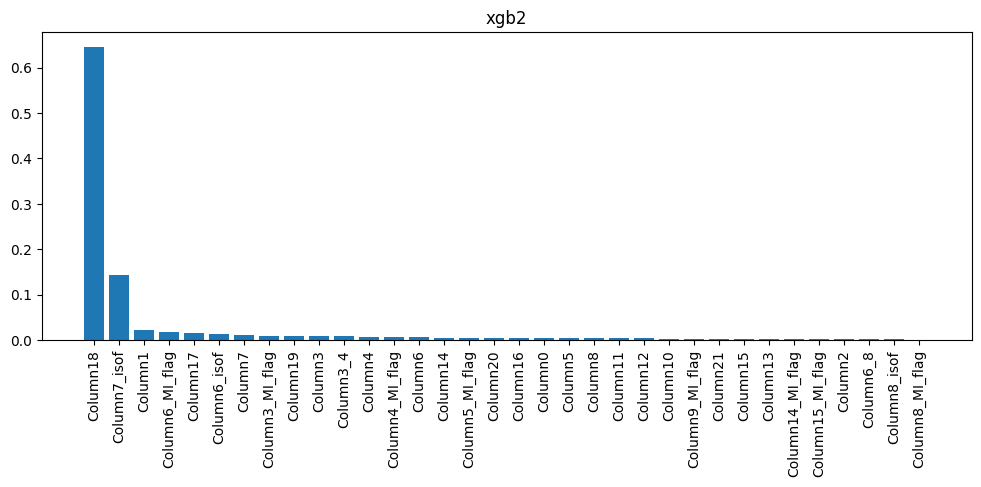

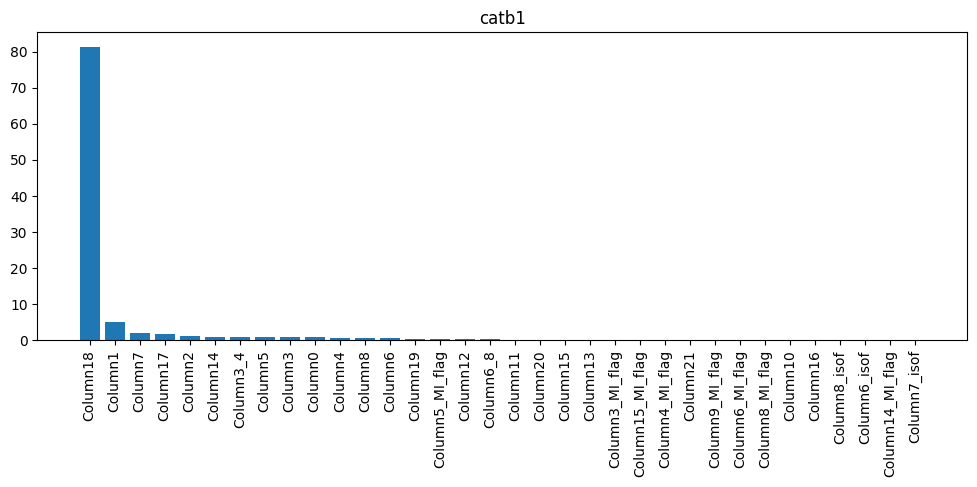

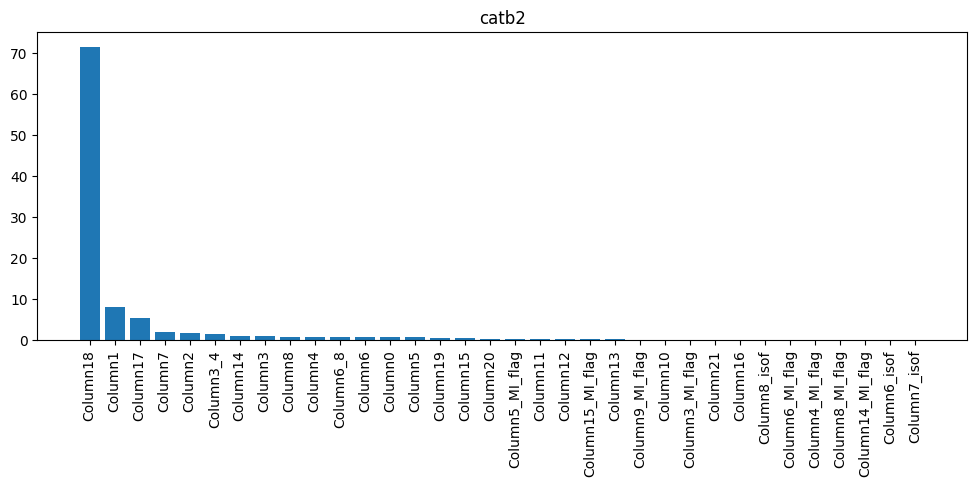

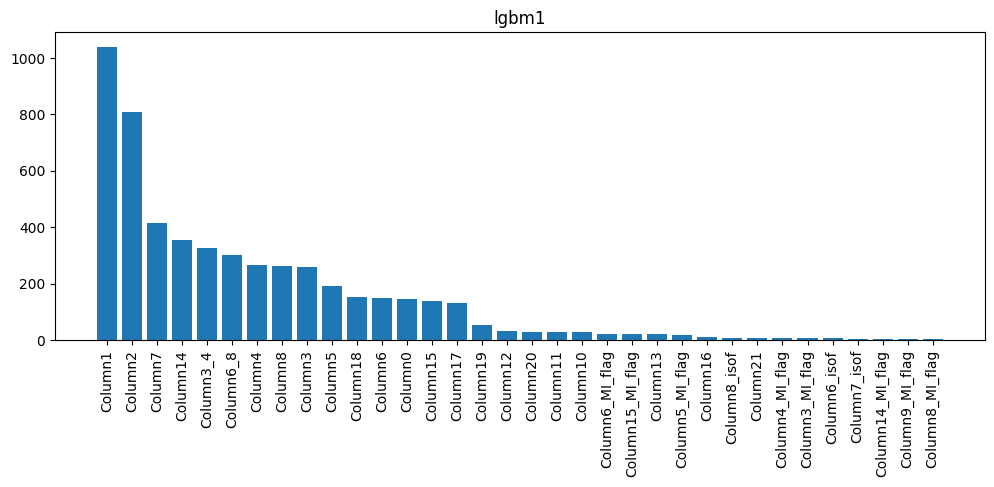

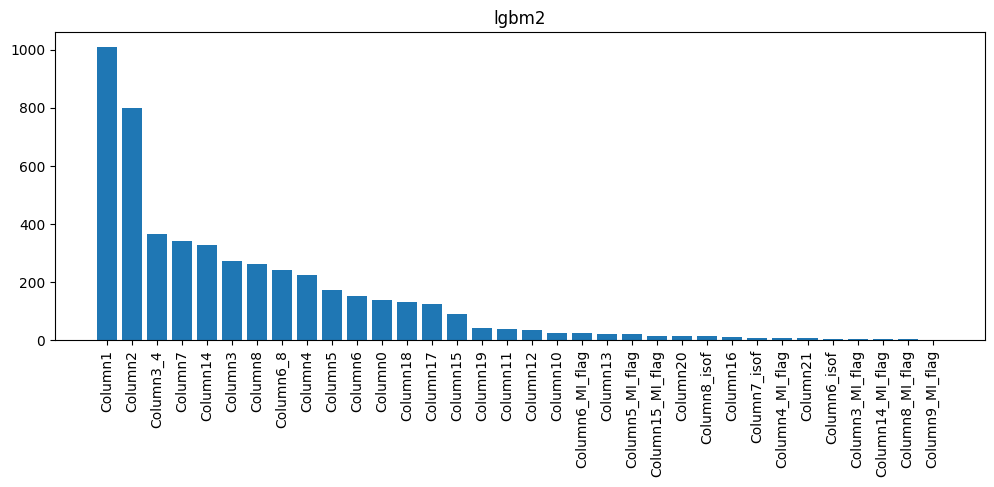

In [9]:
for estimator in primary_estimators:
    if isinstance(estimator['model'], CatBoostClassifier):
        feat_imps = estimator['model'].get_feature_importance(prettified=True)
        plt.figure(figsize=(12,4))
        plt.title(estimator['name'])
        plt.bar(x=feat_imps['Feature Id'], height=feat_imps['Importances'])
        plt.xticks(rotation=90)
        plt.show()

    else:
        feat_imps = list(zip(estimator['model'].feature_names_in_, estimator['model'].feature_importances_))
        feat_imps.sort(key=lambda x:x[1], reverse=True)

        plt.figure(figsize=(12,4))
        plt.title(estimator['name'])
        plt.bar(x=[item[0] for item in feat_imps], height=[item[1] for item in feat_imps])
        plt.xticks(rotation=90)
        plt.show()

In [10]:
from collections import Counter
counter = Counter()
for estimator in primary_estimators:
    if isinstance(estimator['model'], CatBoostClassifier):
        feat_imps = estimator['model'].get_feature_importance(prettified=True)
        counter += Counter([item[0] for item in feat_imps.iloc[-5:].values.tolist()])

    else:
        feat_imps = list(zip(estimator['model'].feature_names_in_, estimator['model'].feature_importances_))
        feat_imps.sort(key=lambda x:x[1], reverse=True)
        counter += Counter([item[0] for item in feat_imps[-5:]])

print(counter)


Counter({'Column9_MI_flag': 4, 'Column8_MI_flag': 4, 'Column6_isof': 4, 'Column14_MI_flag': 4, 'Column16': 3, 'Column8_isof': 3, 'Column7_isof': 3, 'Column10': 2, 'Column14': 2, 'Column15_MI_flag': 2, 'Column2': 2, 'Column6_MI_flag': 1, 'Column21': 1, 'Column15': 1, 'Column13': 1, 'Column6_8': 1, 'Column4_MI_flag': 1, 'Column3_MI_flag': 1})
